In [ ]:
!pip install git

ERROR: Could not find a version that satisfies the requirement git (from versions: none)
ERROR: No matching distribution found for git


In [ ]:
!git clone "https://github.com/FinanceData/marcap.git" marcap

fatal: destination path 'marcap' already exists and is not an empty directory.


In [ ]:
!git clone https://github.com/seokilee0412/Attention_basedGRU.git

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import marcap
from marcap import marcap_data
import matplotlib.pyplot as plt
import datetime
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
pd.options.display.float_format = '{:.2f}'.format

# 데이터 불러오기 / 10년치로 테스트

In [ ]:
# df_year1 = pd.read_csv('marcap/data/marcap-2021.csv.gz', dtype={'Code':str}, parse_dates=['Date'])
# df_year1.head(5)
# 삼성전자 주식은 2018년 5월 3일 이후로 액면분할함
df_2020_samsung = marcap_data('2000-01-01', '2018-05-03', code='005930')

In [ ]:
df_2020_samsung['label'] = np.nan
df_2020_samsung.reset_index(drop=True,inplace=True)

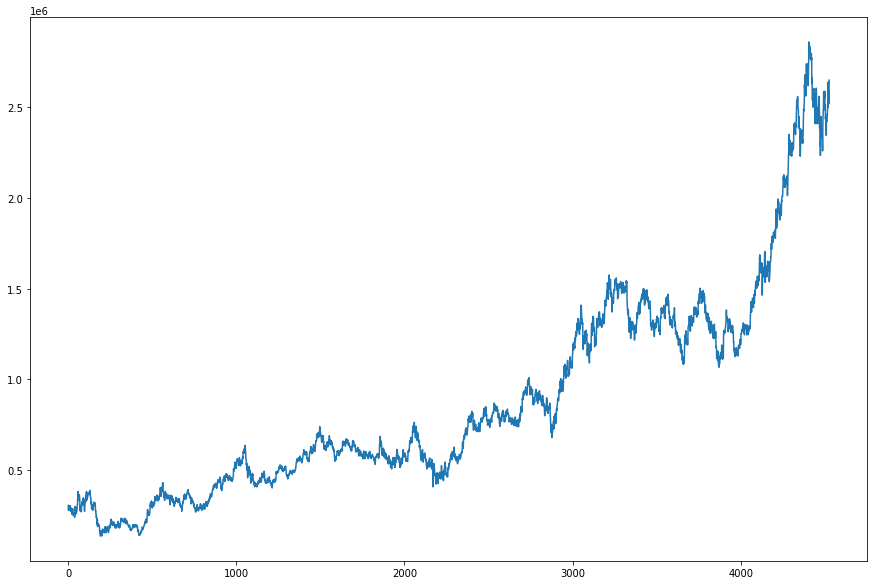

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(df_2020_samsung.Close)
plt.show()

# 데이터 labeling ( 극대, 극소, 비극점)

In [ ]:
#초기 모델이 lookback은 논문에서의 20일을 따름, 종가(Close)를 비교하여 라벨링
def peak_detection(dataset): #Peak Detection

  max = - 100000000
  min =   100000000
  peak_list = set()
  trough_list = set()
  cr = -1
  pr = -1

  for i in range(len(dataset)):
    if dataset.loc[i,'Close'] > max:
      max = dataset.loc[i,'Close']
      max_idx = i
    if dataset.loc[i,'Close'] < min:
      min = dataset.loc[i,'Close']
      min_idx = i

    if dataset.loc[i,'Close'] <= max:
      count = 1
      for j in range(1,20):
        if i+j >= len(dataset):
          break
        if dataset.loc[i+j,'Close'] <= max:
          count +=1
      if count == 20:
        peak_list.add(max_idx)
        cr = max_idx + 20
    if i == cr:
      # print(i)
      max = - 100000000000

    elif dataset.loc[i,'Close'] >= min:
      count = 1
      for j in range(1,20):
        if i+j >= len(dataset):
          break
        if dataset.loc[i+j,'Close'] >= min:
          count += 1
      if count == 20:
        trough_list.add(min_idx)
        pr = min_idx + 20
        # print(pr)
    if i == pr:
      # print(i) 
      min = 100000000000000
  return peak_list, trough_list

In [ ]:
peak_list, trough_list = peak_detection(df_2020_samsung)

# 라벨링한 점들 1차 시각화

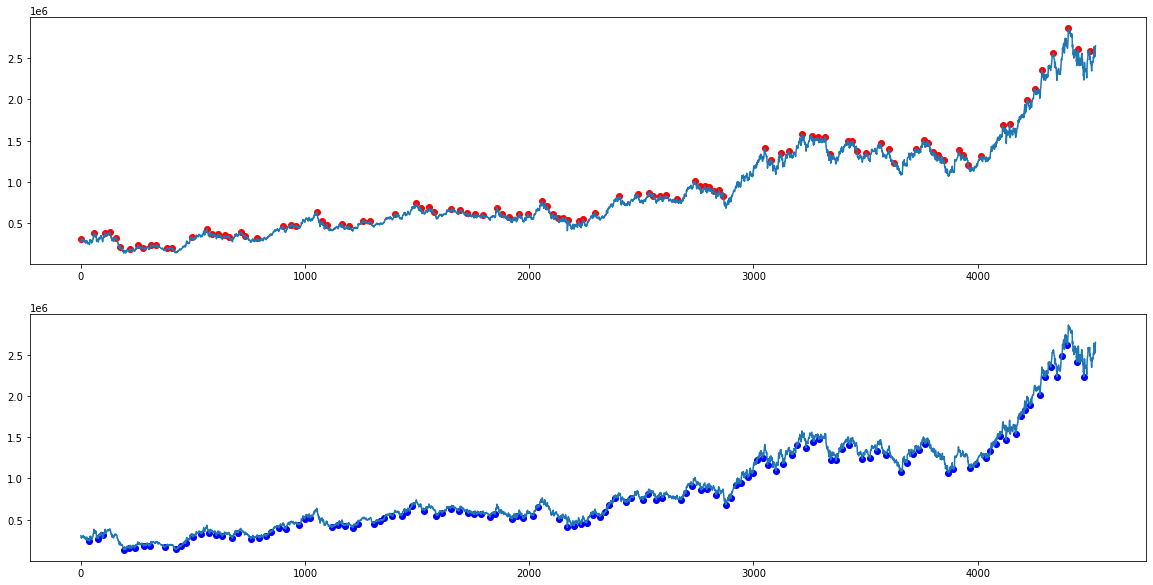

In [ ]:
#라벨링한 극대점 
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(df_2020_samsung['Close'])
plt.scatter(list(peak_list),df_2020_samsung.loc[peak_list,'Close'],color='red')

plt.subplot(212)
plt.plot(df_2020_samsung['Close'])
plt.scatter(list(trough_list),df_2020_samsung.loc[trough_list,'Close'],color='blue')

In [ ]:
 #극점 전후 1일 극점으로 라벨링, 극대 1, 극소 -1, 비극점 0
 #극점에서 6일 이상 떨어진 것들 비극점
def y_labeling(dataset,peak_list,trough_list):
  del_list = set()
  for i in range(len(dataset)):
    if i in peak_list:
      del_list.update([i-2,i-3,i-4,i-5,i-6]) #극점도 비극점에도 쓰이지 않는 데이터
      dataset.loc[i,'label'] = 1
      if i == 0:
        dataset.loc[i+1,'label'] = 1
      elif i == len(dataset):
        dataset.loc[i-1,'label'] = 1
      else:
        dataset.loc[i-1,'label'] = 1
        dataset.loc[i+1,'label'] = 1

    elif i in trough_list:
      del_list.update([i-2,i-3,i-4,i-5,i-6])
      dataset.loc[i,'label'] = -1
      if i == 0:
        dataset.loc[i+1,'label'] = 2
      elif i == len(dataset):
        dataset.loc[i-1,'label'] = 2
      else:
        dataset.loc[i-1,'label'] = 2
        dataset.loc[i+1,'label'] = 2

  del_list = del_list - set(peak_list)
  del_list = del_list - set(trough_list)
  del_list =list(del_list)
  length_data = len(dataset)
  
  # print(del_list)
  true_del_list = []
  for i in range(len(del_list)):
    if del_list[i] >= 0 and del_list[i] <= length_data:
      true_del_list.append(del_list[i])
  # print(true_del_list)
  for i in range(len(dataset)):
    if i not in true_del_list and pd.isna(dataset.loc[i,'label']):
      dataset.loc[i,'label'] = 0
  # print(true_del_list)
  return dataset


In [ ]:
df_2020_samsung = y_labeling(df_2020_samsung,peak_list,trough_list)

# 라벨링한 점 최종 시각화

In [ ]:
idx_0 = df_2020_samsung.loc[df_2020_samsung['label']==0,'Close'].index
idx_1 = df_2020_samsung.loc[df_2020_samsung['label']==1,'Close'].index
idx_1_ = df_2020_samsung.loc[df_2020_samsung['label']==-1,'Close'].index

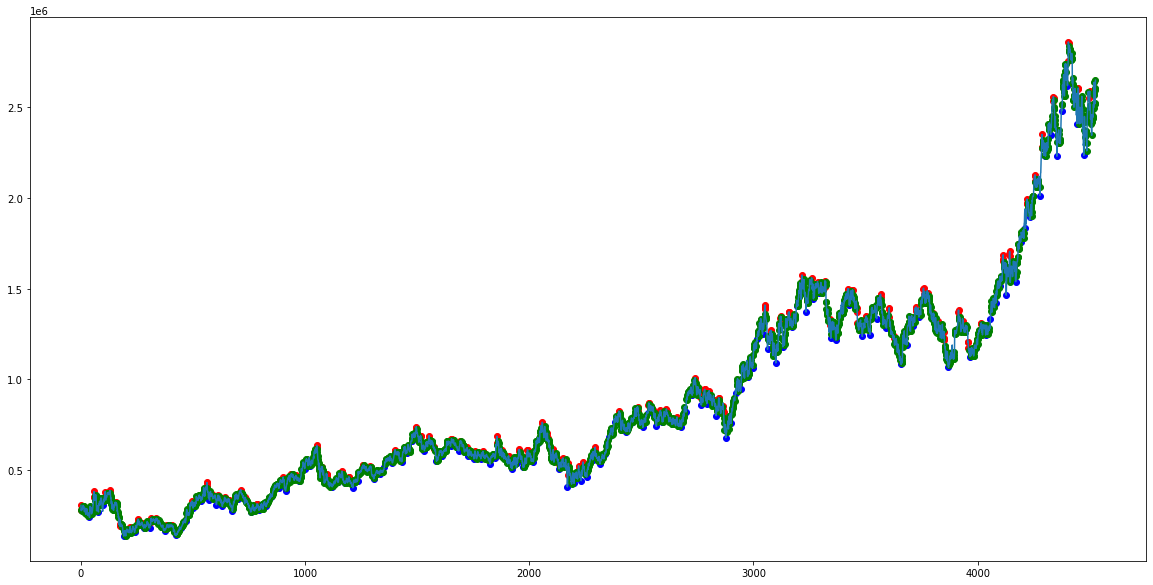

In [ ]:
#라벨링한 극대점 
plt.figure(figsize=(20,10))
plt.plot(df_2020_samsung['Close'])
plt.scatter(idx_1,df_2020_samsung.loc[idx_1,'Close'],color='red')
plt.scatter(idx_1_,df_2020_samsung.loc[idx_1_,'Close'],color='blue')
plt.scatter(idx_0,df_2020_samsung.loc[idx_0,'Close'],color='green')

# X값 보조지표로 바꾸기 - RSI, OBV, Price

In [ ]:
#RSI
def cal_RSI(dataset):
  dataset['RSI'] = 0
  for i in range(len(dataset)):
    if i >=13:
      minus_change = 0
      plus_change = 0
      for j in range(0,14):
        if dataset.loc[i-j,"Changes"] < 0:
          minus_change += dataset.loc[i-j,"Changes"]
        elif dataset.loc[i-j,"Changes"] > 0:
          plus_change += dataset.loc[i-j,"Changes"]
      sum = abs(minus_change) + plus_change
      dataset.loc[i,"RSI"] = plus_change * 100 / sum
  return dataset

In [ ]:
#OBV
def cal_OBV(dataset):
  dataset['OBV'] = 0
  for i in range(len(dataset)):
    if i > 0:
      if dataset.loc[i,'Close'] > dataset.loc[i-1,'Close']:
        dataset.loc[i,'OBV'] = dataset.loc[i-1,'OBV'] + dataset.loc[i,'Volume']
      elif dataset.loc[i,'Close'] < dataset.loc[i-1,'Close']:
        dataset.loc[i,'OBV'] = dataset.loc[i-1,'OBV'] - dataset.loc[i,'Volume']
      else:
        dataset.loc[i,'OBV'] = dataset.loc[i-1,'OBV']
  return dataset

In [ ]:
df_2020_samsung = cal_RSI(df_2020_samsung)

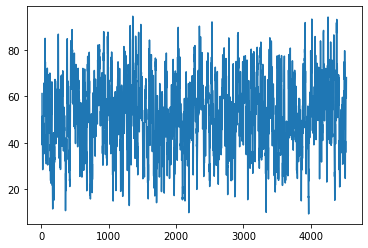

In [ ]:
plt.plot(df_2020_samsung.loc[13:,'RSI'])

In [ ]:
df_2020_samsung = cal_OBV(df_2020_samsung)

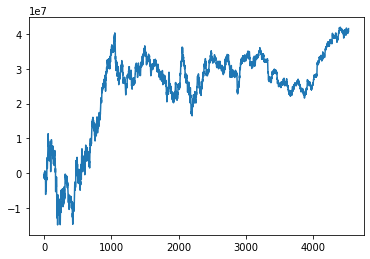

In [ ]:
plt.plot(df_2020_samsung['OBV'])

# Training을 위한 dataset 변환

In [ ]:
def extracting_(dataset,split=False):
  dataset.rename(columns={'Close':'Price'}, inplace=True)
  dataset_x = dataset.loc[:,['Price','RSI','OBV']]
  dataset_y = dataset.loc[:,'label']
  data = pd.concat([dataset_x,dataset_y],axis=1)
  if split:
    return dataset_x, dataset_y
  return data

In [ ]:
def dataset_for_model(dataset,x_features=3,split=False,test_size=300):
  dataset = extracting_(dataset)
  x = []
  y = []
  for i in range(len(dataset)):
    if not pd.isna(dataset.loc[i,'label']):
      if i >=5:
        data = dataset.iloc[i-4:i+1,:]
        data_x = data.loc[:,data.columns != 'label']
        data_y = data.loc[:,'label']
        x.append(np.array(data_x))
        y.append(np.array(data_y)[4])

  x = np.array(x)
  x = torch.from_numpy(x)
  x_rows = x.shape[0]
  y = np.array(y)
  y = torch.from_numpy(y)

  #scaling x
  scaler = MinMaxScaler()
  x = scaler.fit_transform(torch.reshape(x,(-1,x_features)))
  x = torch.from_numpy(x)
  x = torch.reshape(x,(x_rows,-1,x_features))

  #one-hot and argmax
  list_y = []
  for i in range(len(y)):
    z = np.zeros(shape=3,dtype=int)
    if y[i] == 0:
      z[0] = 1
    elif y[i] == 1:
      z[1] = 1
    elif y[i] == -1:
      z[2] = 1
    list_y.append(z)
  list_y = np.array(list_y)
  y = torch.from_numpy(list_y)
  y = torch.argmax(y,dim=1)

  #dataset for training
  if split:
    train_data = TensorDataset(x[:x.size(0)-test_size], y[:x.size(0)-test_size])
    test_data = TensorDataset(x[x.size(0)-test_size:], y[x.size(0)-test_size:])

    train_loader = DataLoader(train_data, shuffle=True, batch_size=1, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)
    return train_loader, test_loader
  else:
    train_data = TensorDataset(x[:train_size], y[:train_size])
    train_loader = DataLoader(train_data, shuffle=True, batch_size=1, drop_last=True)
    return train_loader

In [ ]:
train_loader,test_loader = dataset_for_model(df_2020_samsung,split=True)

# 모델 구성

In [ ]:
class Attention(nn.Module):
  def __init__(self):
    super(Attention,self).__init__()

  def forward(self,x,h):
    x = x[-1][:x.shape[1]-1]
    x = torch.reshape(x,(1,x.shape[0],x.shape[1]))  #마지막 히든스테이트 제외한 것들 > 1, 마지막히든제외, hidden_size
    h = torch.reshape(h,(1,h.shape[1],-1))  #마지막 히든스테이트 값 차원 맞추기
    
    out = torch.sum(torch.mul(x,h),(2))
    out = nn.Softmax()(out)

    # aij * hj
    output_ = torch.Tensor(h.shape)
    for i in range(h.shape[0]):
      for j in range(h.shape[1]):
        output_[i][j] = out[i][j] * h[i][j]
    output_ = torch.sum(output_,dim=(0,1))
    
    output_ = torch.reshape(output_,(1,1,-1))
    output_ = torch.cat((h,output_),dim=0)
    output_ = output_.view(-1)
    
    return output_

In [ ]:
class Attentionbased_GRU(nn.Module):
  def __init__(self,input_size,hidden_size,drop_prob=0,bidirectional=True,num_layers=1,batch_size=1):
    super(Attentionbased_GRU, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.dropout = drop_prob
    self.bidirectional = bidirectional
    self.num_layers = num_layers
    self.batch_size = batch_size

    self.gru = nn.GRU(input_size,hidden_size,dropout=drop_prob,bidirectional=True,batch_first=True)
    self.attention = Attention()
    self.layerdense1 = nn.Linear((input_size+1)*hidden_size,128)
    self.layerdense2 = nn.Linear(128,128)
    self.layerdense3 = nn.Linear(128,64)
    self.layerdense4 = nn.Linear(64,3)
    

    self.tanh = nn.Tanh()
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()

  def forward(self,x):
    out, h_ = self.gru(x)
    out = self.tanh(out)
    out = self.attention(out,h_)
    out = self.layerdense1(self.relu(out))
    out = self.layerdense2(self.relu(out))
    out = self.layerdense3(self.relu(out))
    out = self.layerdense4(self.relu(out))
    out = self.softmax(out)
    return out, h_
  
  # def init_hidden(self):
  #   if self.bidirectional:
  #     return torch.zeros(self.num_layers*2,self.batch_size,self.hidden_size)
  #   else:
  #     return torch.zeros(self.num_layers,self.batch_size,self.hidden_size)

In [ ]:
#https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
model = Attentionbased_GRU(3,60,drop_prob=0.25,bidirectional=True)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
loss_func = FocalLoss()

In [ ]:
optimizer = optim.Adam(model.parameters())

# 모델 학습

In [ ]:
def training(model,optimizer,loss_func,train_loader,epochs):
  loss_arr = []
  for i in range(epochs):
    optimizer.zero_grad()
    loss = 0

    for j, (x,y) in enumerate(train_loader):
      x,y = Variable(x), Variable(y)
      y = y.type(torch.int64)

      predict,_ = model(x.float())
      predict = torch.reshape(predict,(1,-1))
      loss += loss_func(predict,y) 
    
    loss.backward()
    optimizer.step()
    loss_arr.append(loss)

  if i %10 == 0:
    print("%d번째 loss:%d "%(i+1,loss))

  return model, loss_arr

In [ ]:
model,loss_arr = training(model,optimizer,loss_func,train_loader,10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


1번째 loss:3400 


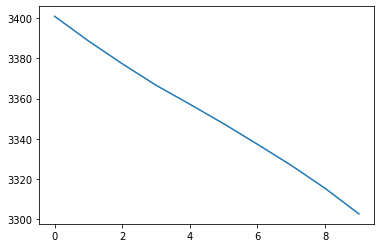

In [ ]:
plt.plot(loss_arr)
plt.show()

#모델 평가

In [ ]:
def testing(testdataloader,model_):
  total = 0
  correct = 0
  model_.eval()
  eval_loss = []
  with torch.no_grad():
    for i,(x,y) in enumerate(testdataloader):
      x,y = Variable(x), Variable(y)
      y = y.type(torch.int64)

      predict,_ = model_(x.float())
      predict,_ = torch.max(predict.data,0)
      total += 1
      correct += (predict==y).sum().item()
  
  print('Accuracy of the network on the %d test images: %d %%' % (total,100 * correct / total))

In [ ]:
testing(test_loader,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 300 test images: 0 %
